In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
import scipy 
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('Fraud.csv')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#### Renaming the columns
(So that is looks readable)

In [4]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


#### Checking data types

In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest           object
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [6]:
df.shape

(6362620, 11)

#### Checking the presence of missing values

In [7]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldBalanceOrig    0
newBalanceOrig    0
nameDest          0
oldBalanceDest    0
newBalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

# EXPLORATORY DATA ANALYSIS

#### Checking fraudlent transactions
(TRANSFER AND CASH_OUT)

In [44]:
print('The types of fraudulent transactions are ={}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 

dft = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfc = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dft))) 

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfc))) 

The types of fraudulent transactions are =['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


#### FlaggedFraud Transactions
(TRANSFER)

In [9]:
print('\nThe type of transactions in which isFlaggedFraud is set: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nMin amount transacted when isFlaggedFraud is set= {}'\
                                  .format(dfFlagged.amount.min()))

print('\nMax amount transacted in a TRANSFER where isFlaggedFraud is not set=\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 



The type of transactions in which isFlaggedFraud is set: ['TRANSFER']

Min amount transacted when isFlaggedFraud is set= 353874.22

Max amount transacted in a TRANSFER where isFlaggedFraud is not set= 92445516.64


#### expected merchant accounts accordingly labelled?

Since, 'M' prefix involves payment by a merchant.

In [10]:
df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M').any()

False

In [11]:
df.nameOrig.str.contains('M').any()

False

In [12]:
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any()

False

In [13]:
(dft.nameDest.isin(dfc.nameOrig)).any()

False

In [14]:
dfNotFraud = df.loc[df.isFraud == 0]

#### Are there account labels common to fraudulent TRANSFERs and CASH_OUTs?

In [15]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dft.loc[dft.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


In [16]:
print('\nFraudulent TRANSFER to C423543548 occured at step = 486 whereas \
genuine CASH_OUT from this account occured earlier at step = {}'.format(\
dfNotFraud.loc[(dfNotFraud.type == 'CASH_OUT') & (dfNotFraud.nameOrig == \
                           'C423543548')].step.values)) # 185


Fraudulent TRANSFER to C423543548 occured at step = 486 whereas genuine CASH_OUT from this account occured earlier at step = [185]


/var/folders/pd/cn2f6bwj5xldgl8r6p_2vr640000gn/T/ipykernel_4345/518261536.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  fraud_check = pd.value_counts(df['isFraud'], sort =True)


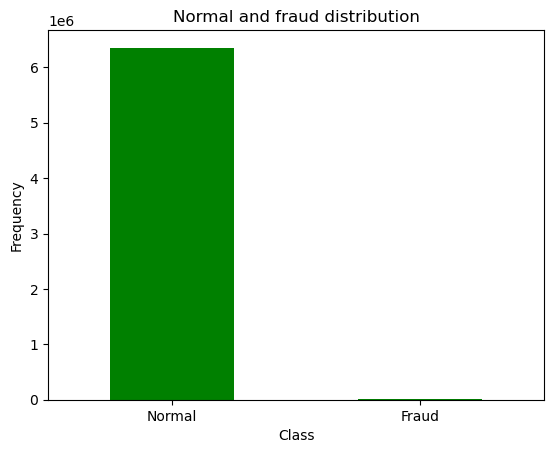

In [17]:
fraud_check = pd.value_counts(df['isFraud'], sort =True)
fraud_check.plot(kind = 'bar', rot=0, color='g')
plt.title("Normal and fraud distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
Labels = ['Normal','Fraud']
plt.xticks(range(2), Labels)
plt.show()

In [18]:
fraud_people = df[df['isFraud']==1]
normal_people = df[df['isFraud']==0]

In [19]:
fraud_people.shape

(8213, 11)

In [20]:
normal_people.shape

(6354407, 11)

In [21]:
fraud_people['amount'].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [22]:
normal_people['amount'].describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

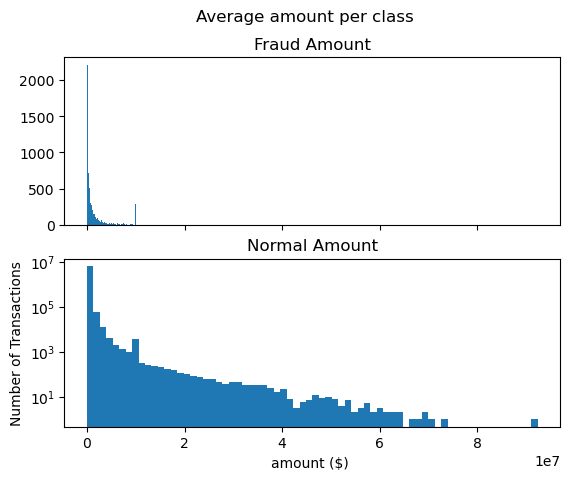

In [45]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex = True) 
graph.suptitle("Average amount per class")
bins = 70

plot1.hist(fraud_people['amount'], bins = bins)
plot1.set_title('Fraud Amount')

plot2.hist(normal_people['amount'], bins = bins)
plot2.set_title('Normal Amount')

plt.xlabel('amount ($) ')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

In [24]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldBalanceOrig    float64
newBalanceOrig    float64
nameDest           object
oldBalanceDest    float64
newBalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [46]:
columns = df.columns.tolist()
columns = [var for var in columns if var not in ["isFraud"]]
target = "isFraud"
x = df[columns]
y = df[target]

In [26]:
x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)

/var/folders/pd/cn2f6bwj5xldgl8r6p_2vr640000gn/T/ipykernel_4345/1353995510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['type'].replace(['CASH_IN','CASH_OUT','DEBIT','PAYMENT','TRANSFER'],['1','2','3','4','5',], inplace=True)


In [27]:
x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)
x.head()

/var/folders/pd/cn2f6bwj5xldgl8r6p_2vr640000gn/T/ipykernel_4345/3751962154.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.drop(['nameOrig','nameDest','isFlaggedFraud'],axis=1, inplace=True)


,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest
0,1,4,9839.64,170136.0,160296.36,0.0,0.0
1,1,4,1864.28,21249.0,19384.72,0.0,0.0
2,1,5,181.00,181.0,0.00,0.0,0.0
3,1,2,181.00,181.0,0.00,21182.0,0.0
4,1,4,11668.14,41554.0,29885.86,0.0,0.0


In [28]:
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.30, random_state = 42)

In [30]:
iso_forest = IsolationForest(n_estimators =100, max_samples = len(x_train), random_state=0, verbose=0)

In [31]:
iso_forest.fit(x_train,y_train)

IsolationForest(max_samples=4453834, random_state=0)

In [32]:
ypred = iso_forest.predict(x_test)

In [33]:
ypred[ypred == 1] = 0
ypred[ypred == -1] = 1

In [34]:
print(accuracy_score(y_test,ypred))

0.9931794344677717


In [35]:
print(classification_report(y_test,ypred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00   1906351
           1       0.05      0.22      0.08      2435

    accuracy                           0.99   1908786
   macro avg       0.52      0.61      0.54   1908786
weighted avg       1.00      0.99      1.00   1908786



In [36]:
from sklearn.metrics import confusion_matrix

In [37]:
confusion_matrix(y_test, ypred)

array([[1895225,   11126],
       [   1893,     542]])

In [38]:
n_erorrs = (ypred != y_test).sum()
print("Isolation Forest have {} erorrs.".format(n_erorrs))

Isolation Forest have 13019 erorrs.


### ANSWERING THE QUESTIONS

1. The data didnt include any missing/ null values, I performed a check for this. For outlier detection I have used IsolationForest which I imported from sklearn.ensemble library.

2. So basically, my fraud detection model detects what types of transaction are fraudlents and in this model we drop the features that do not encode with the merchant account. In this model we also see the distribution graphically. I've used the Isolation Forest for our Anamoly Detection.
ISOLATION FOREST: The algorithm is based on the fact that anomalies that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.
So, by this method the model gave an accuracy score of more than 0.99. At last I've also checked the errors my model have.

3. I selected the variables on the basis of their use, for training the model I've taken 'x' as coloumn of the data provided, 'y' as target. x_train and y_train to train the data and x_test, y_test to test the trained model data.

4. So firstly, the prepared data is loaded by using pandas library, then the data is cleaned if any null value is present or not. After that we train our model, firstly we choose the model and then train it accordingly. Then we can visualise our model by seaborn libraries.

5. Key factors typically includes ;
a)Transactional Features:
Transaction Amount, Transaction Frequency, Merchant Type. Unusual large transactions happening, High frequency of transaction or transactions happening with certain type of merchants may be prone to fraud.
b)Customer Behavior: Age and Gender, Income Level, Employment Status
c)Historical Data : Previous Fraud Incidents, Credit Score, Transaction Reversals
   ###### In machine learning we detect fraud transactions by help of outliers and anomalies.

6. Yes, these factors do make sense for predicting fraudulent customers. Each factor is logically associated with patterns of behavior that are often observed in fraudulent activities.
Detecting outliers in transaction amounts helps identify potentially fraudulent transactions.
Monitoring frequency helps flag accounts with suspiciously high transaction rates.
Analyzing transaction times can reveal abnormal activity patterns.
Transactions with high-risk merchants can be given extra scrutiny.
Detecting outliers helps focus attention on the most suspicious transactions.

7. Data Encryption, Access Control and Authentication, Access Control and Authentication, Incident Response Plan, Vendor and Third-Party Management, Monitoring and Logging

8. Determining the effectiveness of the implemented preventive actions requires continuous monitoring, evaluation, and adjustment.
Key Performance Indicators (KPIs) and Metrics, Incident Response Testing, User Feedback and Training Effectiveness, Review and Continuous Improvement